In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline

try:
    gpu = tf.distribute.cluster_resolver.GPUClusterResolver()
    print('Device:', gpu.master())
    tf.config.experimental_connect_to_cluster(gpu)
    tf.tpu.experimental.initialize_tpu_system(gpu)
    strategy = tf.distribute.experimental.GPUStrategy(gpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

2023-02-08 16:36:28.450594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of replicas: 1
2.11.0


In [2]:
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [4]:
# Load the data

ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

2023-02-08 16:36:33.984443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


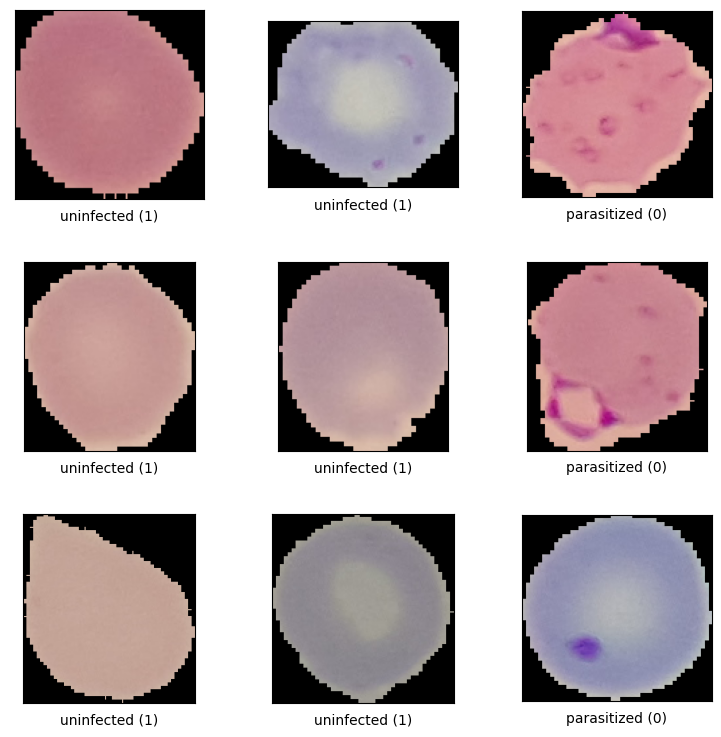

In [6]:
vis = tfds.visualization.show_examples(ds, info)

In [7]:
train_images = []
train_labels = []

for example in ds:
    train_images.append(example['image'].numpy())
    train_labels.append(example['label'].numpy())

In [8]:
print(f'Shape of image 1: {train_images[0].shape[0]}x{train_images[0].shape[1]}')
print(f'Shape of image 2: {train_images[1].shape[0]}x{train_images[1].shape[1]}')

Shape of image 1: 151x115
Shape of image 2: 121x115


Our images are not uniformally sized, so we will need to deal with that. Let's do some more inspection on that.

In [9]:
images_flattened = [x.flatten().astype('float64') for x in train_images]

In [10]:
img_lengths = []

for img in images_flattened:
    img_lengths.append(len(img))

In [11]:
img_lengths = np.array(img_lengths)

In [12]:
uninfected_lengths = img_lengths[np.array(train_labels) == 1]
parasitized_lengths = img_lengths[np.array(train_labels) == 0]

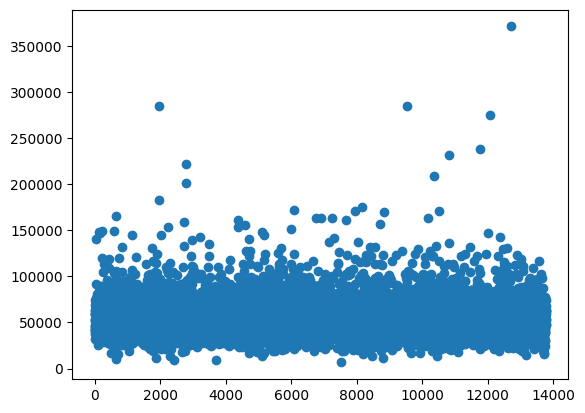

In [13]:
plt.scatter(np.arange(len(parasitized_lengths)), parasitized_lengths)

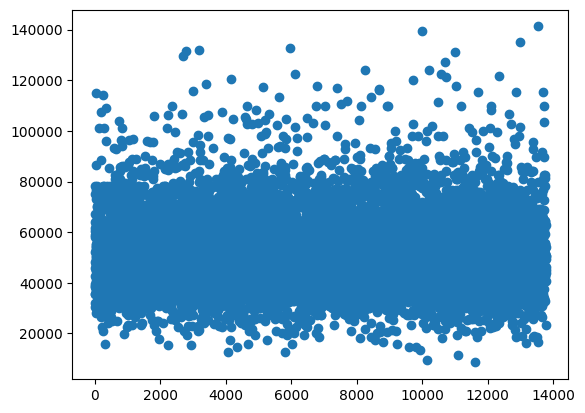

In [14]:
plt.scatter(np.arange(len(uninfected_lengths)), uninfected_lengths)

In [15]:
dim_x = []
dim_y = []
cell_class = []
dim_colors = []

for i, img in enumerate(train_images):
    y, x, colors = img.shape
    dim_x.append(x)
    dim_y.append(y)
    cell_class.append(train_labels[i])
    dim_colors.append(colors)

In [16]:
dims_df = pd.DataFrame([dim_x, dim_y, cell_class]).T.rename(columns={0: 'dim_x', 1: 'dim_y', 2: 'class'})
dims_df['pixel_count'] = dims_df.dim_x * dims_df.dim_y
dims_df

,dim_x,dim_y,class,pixel_count
0,115,151,1,17365
1,115,121,0,13915
2,136,157,0,21352
3,148,151,1,22348
4,112,133,0,14896
...,...,...,...,...
27553,124,136,1,16864
27554,136,124,1,16864
27555,133,124,1,16492
27556,127,115,1,14605


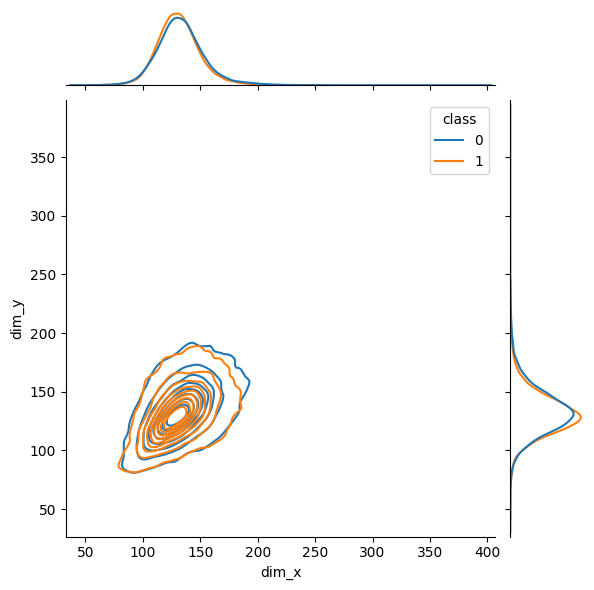

In [17]:
sns.jointplot(data=dims_df, x='dim_x', y='dim_y', hue='class', kind='kde')
plt.show()

In [18]:
image_shape = (int(round(np.max(dim_y),0)), int(round(np.max(dim_x),0)), 3)

print(f'Max dim_x size is {image_shape[1]}')
print(f'Max dim_y size is {image_shape[0]}')
print(f'Used image shape is {image_shape}')

Max dim_x size is 394
Max dim_y size is 385
Used image shape is (385, 394, 3)


In [19]:
# Free up RAM

del ds, info, train_images, train_labels, images_flattened, img_lengths, dim_x, dim_y, dims_df, uninfected_lengths, parasitized_lengths
del cell_class, dim_colors

In [20]:
BATCH_SIZE = 128
IMAGE_SIZE = (200,200,3)

train_ds, val_ds, test_ds = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True, seed=42)

In [21]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: 19291
Num validating images: 4133
Num testing images: 4134


In [22]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

def pad(image,label):
    image,label = convert(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE[0], IMAGE_SIZE[1])
    return image,label

In [23]:
padded_train_ds = (
    train_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

padded_val_ds = (
    val_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

padded_test_ds = (
    test_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

In [24]:
image_batch, label_batch = next(iter(padded_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

2023-02-08 16:37:06.206891: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


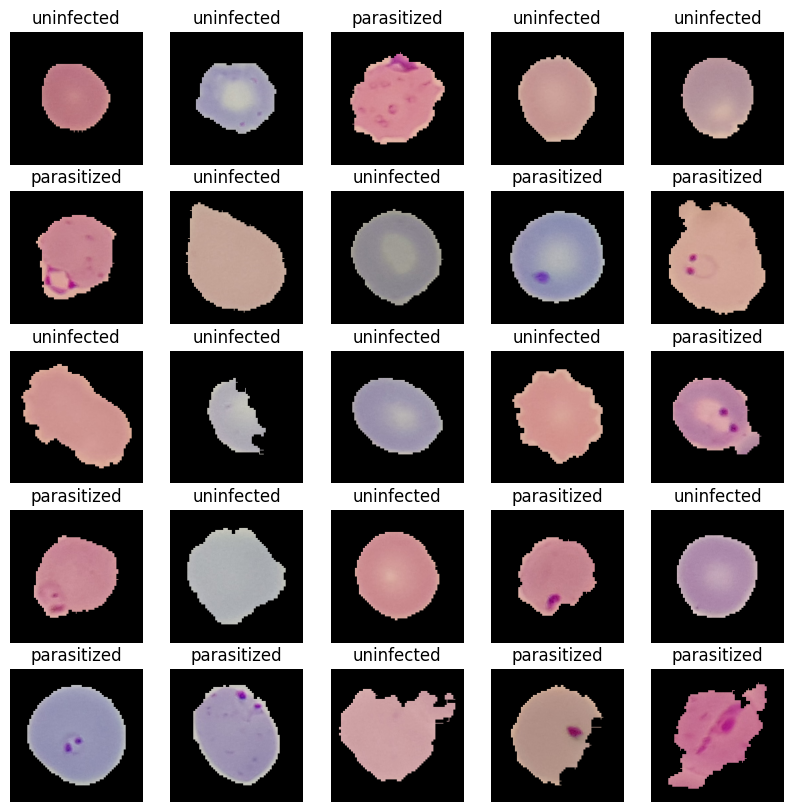

In [25]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

print(datetime.now().strftime("%Y-%m-%d--%H%M"))
log_directory = f'cnn_cell/simple_model/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}'
print(log_directory)

2023-02-08--1637
cnn_cell/simple_model/fit/20230208-163707


In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

In [29]:
simple_model = Sequential()

simple_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
simple_model.add(
    MaxPool2D(pool_size=(2,2))
)
    
simple_model.add(Flatten())
    
simple_model.add(Dense(32, activation='relu'))
simple_model.add(Dropout(0.5))

simple_model.add(Dense(1, activation='sigmoid'))

simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 313632)            0         
                                                                 
 dense (Dense)               (None, 32)                10036256  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                        

In [31]:
board = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

2023-02-08 16:37:07.845767: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-08 16:37:07.845781: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-02-08 16:37:07.846083: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [39]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("shallow_malaria_model.h5",
                                                    save_best_only=True)

In [32]:
simple_model.fit(padded_train_ds, epochs=20, validation_data=padded_val_ds, callbacks=[early_stop, board, check_point])

Epoch 1/20
  1/151 [..............................] - ETA: 5:07 - loss: 0.6790 - accuracy: 0.5859

2023-02-08 16:37:10.047601: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-08 16:37:10.047615: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


  2/151 [..............................] - ETA: 2:33 - loss: 9.7133 - accuracy: 0.5469

2023-02-08 16:37:11.057827: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-08 16:37:11.070056: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-02-08 16:37:11.073986: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: cnn_cell/simple_model/fit/20230208-163707/plugins/profile/2023_02_08_16_37_11/HOBNJML-C40PLVD.xplane.pb


151/151 [==============================] - 171s 1s/step - loss: 1.1482 - accuracy: 0.5396 - val_loss: 0.6768 - val_accuracy: 0.6242
Epoch 2/20
151/151 [==============================] - 168s 1s/step - loss: 0.6776 - accuracy: 0.5662 - val_loss: 0.6656 - val_accuracy: 0.6429
Epoch 3/20
151/151 [==============================] - 172s 1s/step - loss: 0.6705 - accuracy: 0.5850 - val_loss: 0.6541 - val_accuracy: 0.6632
Epoch 4/20
151/151 [==============================] - 177s 1s/step - loss: 0.6599 - accuracy: 0.5999 - val_loss: 0.6444 - val_accuracy: 0.7244
Epoch 5/20
151/151 [==============================] - 170s 1s/step - loss: 0.6458 - accuracy: 0.6177 - val_loss: 0.6285 - val_accuracy: 0.7414
Epoch 6/20
151/151 [==============================] - 170s 1s/step - loss: 0.6239 - accuracy: 0.6410 - val_loss: 0.5947 - val_accuracy: 0.7513
Epoch 7/20
151/151 [==============================] - 173s 1s/step - loss: 0.5793 - accuracy: 0.7275 - val_loss: 0.5310 - val_accuracy: 0.8485
Epoch 8/20

Model performance was pretty good, but we can probably do better. Let's try a deeper CNN.

In [40]:
deep_model = Sequential()

deep_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deep_model.add(
    MaxPool2D(pool_size=(2,2))
)

deep_model.add(
    Conv2D(filters=64, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deep_model.add(
    MaxPool2D(pool_size=(2,2))
)
    
deep_model.add(
    Conv2D(filters=64, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deep_model.add(
    MaxPool2D(pool_size=(2,2))
)
    
deep_model.add(Flatten())
    
deep_model.add(Dense(128, activation='relu'))
deep_model.add(Dropout(0.5))

deep_model.add(Dense(1, activation='sigmoid'))

deep_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
deep_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 64)      

In [42]:
print(datetime.now().strftime("%Y-%m-%d--%H%M"))
log_directory = f'cnn_cell/deep_model/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}'
print(log_directory)

2023-02-09--0841
cnn_cell/deep_model/fit/20230209-084141


In [43]:
board = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

2023-02-09 08:41:42.159243: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-09 08:41:42.159269: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-02-09 08:41:42.161918: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [44]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("deep_malaria_model.h5",
                                                    save_best_only=True)

In [45]:
deep_model.fit(padded_train_ds, epochs=20, validation_data=padded_val_ds, callbacks=[early_stop, board, checkpoint])

Epoch 1/20
  1/151 [..............................] - ETA: 11:00 - loss: 0.6882 - accuracy: 0.5938

2023-02-09 08:41:50.960456: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-09 08:41:50.960470: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


  2/151 [..............................] - ETA: 12:23 - loss: 0.8804 - accuracy: 0.5547

2023-02-09 08:41:55.930928: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-09 08:41:55.939396: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-02-09 08:41:55.944549: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: cnn_cell/deep_model/fit/20230209-084141/plugins/profile/2023_02_09_08_41_55/HOBNJML-C40PLVD.xplane.pb


151/151 [==============================] - 378s 2s/step - loss: 0.5786 - accuracy: 0.6979 - val_loss: 0.3737 - val_accuracy: 0.8355
Epoch 2/20
151/151 [==============================] - 363s 2s/step - loss: 0.2366 - accuracy: 0.9155 - val_loss: 0.1640 - val_accuracy: 0.9400
Epoch 3/20
151/151 [==============================] - 361s 2s/step - loss: 0.1712 - accuracy: 0.9401 - val_loss: 0.1463 - val_accuracy: 0.9528
Epoch 4/20
151/151 [==============================] - 370s 2s/step - loss: 0.1496 - accuracy: 0.9499 - val_loss: 0.1450 - val_accuracy: 0.9519
Epoch 5/20
151/151 [==============================] - 364s 2s/step - loss: 0.1282 - accuracy: 0.9567 - val_loss: 0.1469 - val_accuracy: 0.9528
Epoch 6/20
151/151 [==============================] - 364s 2s/step - loss: 0.1131 - accuracy: 0.9618 - val_loss: 0.1528 - val_accuracy: 0.9516
Epoch 7/20
151/151 [==============================] - 366s 2s/step - loss: 0.0936 - accuracy: 0.9681 - val_loss: 0.1615 - val_accuracy: 0.9502


The deep model is performing much better, well enough that we should report on it.

In [46]:
metrics = pd.DataFrame(deep_model.history.history)

<AxesSubplot: >

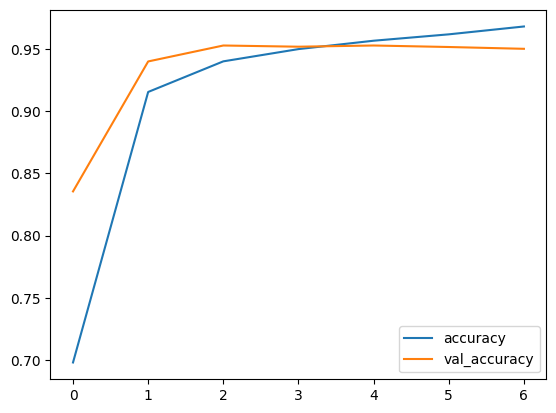

In [47]:
metrics[['accuracy', 'val_accuracy']].plot()

<AxesSubplot: >

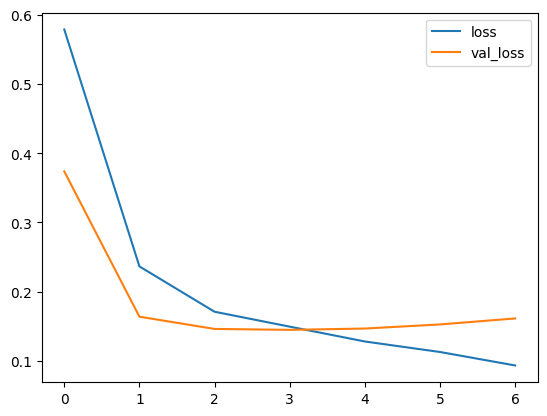

In [48]:
metrics[['loss', 'val_loss']].plot()

In [49]:
from sklearn.metrics import confusion_matrix, classification_report

In [50]:
y_test = tf.concat([y for x, y in padded_test_ds], axis=0)

In [145]:
# Recall that 1 represents uninfected, so by requiring the
# cutoff to be high, we are saying that we are requiring our 
# model to be quite confident in order to except its labeling
# an input as 'malaria free', i.e., we are pushing for 
# a low false-positive rate (recalling that positive=1 is actually
# negative for malaria).

y_pred = deep_model.predict(padded_test_ds) > 0.9 

33/33 [==============================] - 17s 517ms/step


In [148]:
(1 - np.array(y_test)).sum() # Total true parasitized

2086

In [149]:
(1 - y_pred).sum() # Total predicted parasitized

2211

In [152]:
cm = confusion_matrix(y_test, y_pred)
print(cm.ravel())
print(cm)

[1998   88  213 1835]
[[1998   88]
 [ 213 1835]]


In [135]:
label_dict = {0: 'parasitized', 1: 'uninfected'}

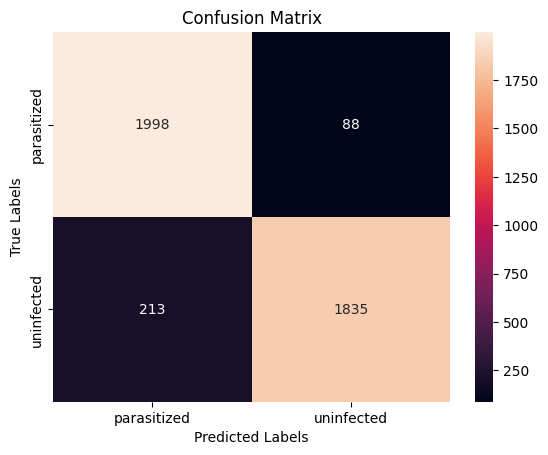

In [153]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted Labels');
ax.set_ylabel('True Labels')
ax.set_xticklabels(label_dict.values(), rotation='horizontal')
ax.set_yticklabels(label_dict.values(), rotation='vertical')
ax.set_title('Confusion Matrix'); 

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2086
           1       0.95      0.90      0.92      2048

    accuracy                           0.93      4134
   macro avg       0.93      0.93      0.93      4134
weighted avg       0.93      0.93      0.93      4134



In [129]:
def auc_score(tps, fps):
    area = 0
    for i in range(1,len(tps)):
        left, right = fps[i-1], fps[i]
        bottom, top = tps[i-1], tps[i]
        if i == 1:
            left = 0, 
            bottom = 0
        elif i == len(tps)-1:
            right = 1, 
            top = 1
        area += (top + bottom) * (right - left)/2
    return area

Let's try one more deeper model to see if we can get any improvement.

In [58]:
deeper_model = Sequential()

deeper_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deeper_model.add(
    MaxPool2D(pool_size=(2,2))
)

deeper_model.add(
    Conv2D(filters=64, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deeper_model.add(
    MaxPool2D(pool_size=(2,2))
)
    
deeper_model.add(
    Conv2D(filters=128, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deeper_model.add(
    MaxPool2D(pool_size=(2,2))
)

deeper_model.add(
    Conv2D(filters=256, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deeper_model.add(
    MaxPool2D(pool_size=(2,2))
)

deeper_model.add(
    Conv2D(filters=512, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deeper_model.add(
    MaxPool2D(pool_size=(2,2))
)
    
deeper_model.add(Flatten())
    
deeper_model.add(Dense(128, activation='relu'))
deeper_model.add(Dropout(0.5))

deeper_model.add(Dense(1, activation='sigmoid'))

deeper_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
deeper_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 128)     

In [60]:
print(datetime.now().strftime("%Y-%m-%d--%H%M"))
log_directory = f'cnn_cell/deeper_model/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}'
print(log_directory)

2023-02-09--1033
cnn_cell/deeper_model/fit/20230209-103349


In [61]:
board = TensorBoard(log_dir=log_directory, histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

2023-02-09 10:33:50.313842: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-09 10:33:50.313873: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-02-09 10:33:50.314642: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [63]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("deeper_malaria_model.h5", save_best_only=True)


In [66]:
deeper_model.fit(padded_train_ds, epochs=20, validation_data=padded_val_ds, callbacks=[early_stop, board, checkpoint])

Epoch 1/20
  1/151 [..............................] - ETA: 13:40 - loss: 0.6922 - accuracy: 0.5469

2023-02-09 10:34:39.329350: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-09 10:34:39.329361: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


  2/151 [..............................] - ETA: 10:38 - loss: 0.7166 - accuracy: 0.5312

2023-02-09 10:34:43.602648: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-09 10:34:43.606875: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-02-09 10:34:43.608527: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: cnn_cell/deeper_model/fit/20230209-103349/plugins/profile/2023_02_09_10_34_43/HOBNJML-C40PLVD.xplane.pb


151/151 [==============================] - 472s 3s/step - loss: 0.4695 - accuracy: 0.7505 - val_loss: 0.1725 - val_accuracy: 0.9441
Epoch 2/20
151/151 [==============================] - 476s 3s/step - loss: 0.1553 - accuracy: 0.9530 - val_loss: 0.1298 - val_accuracy: 0.9598
Epoch 3/20
151/151 [==============================] - 484s 3s/step - loss: 0.1403 - accuracy: 0.9585 - val_loss: 0.1230 - val_accuracy: 0.9596
Epoch 4/20
151/151 [==============================] - 487s 3s/step - loss: 0.1320 - accuracy: 0.9586 - val_loss: 0.1349 - val_accuracy: 0.9603
Epoch 5/20
151/151 [==============================] - 496s 3s/step - loss: 0.1216 - accuracy: 0.9616 - val_loss: 0.1181 - val_accuracy: 0.9591
Epoch 6/20
151/151 [==============================] - 503s 3s/step - loss: 0.1184 - accuracy: 0.9614 - val_loss: 0.1196 - val_accuracy: 0.9601
Epoch 7/20
151/151 [==============================] - 479s 3s/step - loss: 0.1102 - accuracy: 0.9631 - val_loss: 0.1177 - val_accuracy: 0.9603
Epoch 8/20

In [65]:
from tensorflow.keras.layers import BatchNormalization

In [67]:
deeper_bn_model = Sequential()

deeper_bn_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deeper_bn_model.add(
    BatchNormalization()
)
deeper_bn_model.add(
    MaxPool2D(pool_size=(2,2))
)

deeper_bn_model.add(
    Conv2D(filters=64, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deeper_bn_model.add(
    BatchNormalization()
)
deeper_bn_model.add(
    MaxPool2D(pool_size=(2,2))
)
    
deeper_bn_model.add(
    Conv2D(filters=128, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deeper_bn_model.add(
    BatchNormalization()
)
deeper_bn_model.add(
    MaxPool2D(pool_size=(2,2))
)

deeper_bn_model.add(
    Conv2D(filters=256, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deeper_bn_model.add(
    BatchNormalization()
)
deeper_bn_model.add(
    MaxPool2D(pool_size=(2,2))
)

deeper_bn_model.add(
    Conv2D(filters=512, kernel_size=(3,3), input_shape=IMAGE_SIZE, activation='relu')
)
deeper_bn_model.add(
    BatchNormalization()
)
deeper_bn_model.add(
    MaxPool2D(pool_size=(2,2))
)
    
deeper_bn_model.add(Flatten())
    
deeper_bn_model.add(Dense(128, activation='relu'))
deeper_bn_model.add(Dropout(0.5))

deeper_bn_model.add(Dense(1, activation='sigmoid'))

deeper_bn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [68]:
deeper_bn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 97, 97, 64)       256       
 hNormalization)                                                 
                                                      

In [69]:
print(datetime.now().strftime("%Y-%m-%d--%H%M"))
log_directory = f'cnn_cell/deeper_bn_model/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}'
print(log_directory)

2023-02-09--1155
cnn_cell/deeper_bn_model/fit/20230209-115531


In [70]:
board = TensorBoard(log_dir=log_directory, histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

2023-02-09 11:55:31.129833: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-09 11:55:31.129891: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-02-09 11:55:31.130786: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [72]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("deeper_bn_malaria_model.h5", save_best_only=True)


In [73]:
deeper_bn_model.fit(padded_train_ds, epochs=20, validation_data=padded_val_ds, callbacks=[early_stop, board, checkpoint])

Epoch 1/20
  1/151 [..............................] - ETA: 23:55 - loss: 1.4429 - accuracy: 0.5078

2023-02-09 12:01:53.821306: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-09 12:01:53.821317: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


  2/151 [..............................] - ETA: 14:44 - loss: 12.7189 - accuracy: 0.5117

2023-02-09 12:01:59.743595: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-09 12:01:59.748349: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-02-09 12:01:59.752174: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: cnn_cell/deeper_bn_model/fit/20230209-115531/plugins/profile/2023_02_09_12_01_59/HOBNJML-C40PLVD.xplane.pb


151/151 [==============================] - 789s 5s/step - loss: 0.8359 - accuracy: 0.6265 - val_loss: 0.6979 - val_accuracy: 0.4965
Epoch 2/20
151/151 [==============================] - 823s 5s/step - loss: 0.2637 - accuracy: 0.9222 - val_loss: 0.9374 - val_accuracy: 0.5892
Epoch 3/20
151/151 [==============================] - 758s 5s/step - loss: 0.1776 - accuracy: 0.9494 - val_loss: 0.2259 - val_accuracy: 0.9446
Epoch 4/20
151/151 [==============================] - 840s 6s/step - loss: 0.1614 - accuracy: 0.9543 - val_loss: 0.1909 - val_accuracy: 0.9388
Epoch 5/20
151/151 [==============================] - 764s 5s/step - loss: 0.1456 - accuracy: 0.9555 - val_loss: 0.1242 - val_accuracy: 0.9596
Epoch 6/20
151/151 [==============================] - 666s 4s/step - loss: 0.1379 - accuracy: 0.9571 - val_loss: 0.1249 - val_accuracy: 0.9579
Epoch 7/20
151/151 [==============================] - 765s 5s/step - loss: 0.1273 - accuracy: 0.9597 - val_loss: 0.1219 - val_accuracy: 0.9610
Epoch 8/20

In [74]:
shallow_y_proba = simple_model.predict(padded_test_ds)
deep_y_proba = deep_model.predict(padded_test_ds)
deeper_y_proba = deeper_model.predict(padded_test_ds)
deeper_bn_y_proba = deeper_bn_model.predict(padded_test_ds)

33/33 [==============================] - 37s 1s/step


In [187]:
# Note that our class labels are counter to what is typical in medical field, i.e., in our case
# 0 = negative = parasitized and 1 = positive = uninfected.  To correct for this, we can just 
# apply 1 - to the true and predicted labels when computing the confusion matrices

shallow_tps = []
shallow_fps = []

for i in range(1001):
    class_preds = shallow_y_proba >= i/1000
    cm = confusion_matrix(1 - y_test, 1 - class_preds)
    tn, fp, fn, tp = cm.ravel()
    shallow_tps.append(tp/(tp + fn))
    shallow_fps.append(fp/(fp + tn))
    

deep_tps = []
deep_fps = []

for i in range(1001):
    class_preds = deep_y_proba >= i/1000
    cm = confusion_matrix(1 - y_test, 1 - class_preds)
    tn, fp, fn, tp = cm.ravel()
    deep_tps.append(tp/(tp + fn))
    deep_fps.append(fp/(fp + tn))
    

deeper_tps = []
deeper_fps = []

for i in range(1001):
    class_preds = deeper_y_proba >= i/1000
    cm = confusion_matrix(1 - y_test, 1 - class_preds)
    tn, fp, fn, tp = cm.ravel()
    deeper_tps.append(tp/(tp + fn))
    deeper_fps.append(fp/(fp + tn))
    

deeper_bn_tps = []
deeper_bn_fps = []


for i in range(1001):
    class_preds = deeper_bn_y_proba >= i/1000
    cm = confusion_matrix(1 - y_test, 1 - class_preds)
    tn, fp, fn, tp = cm.ravel()
    deeper_bn_tps.append(tp/(tp + fn))
    deeper_bn_fps.append(fp/(fp + tn))

In [188]:
shallow_roc_data = pd.DataFrame([shallow_fps, shallow_tps]).T
shallow_roc_data = shallow_roc_data.rename(columns={0:'fpr', 1:'tpr'})
shallow_roc_data['model'] = 'shallow-model'

deep_roc_data = pd.DataFrame([deep_fps, deep_tps]).T
deep_roc_data = deep_roc_data.rename(columns={0:'fpr', 1:'tpr'})
deep_roc_data['model'] = 'deep-model'

deeper_roc_data = pd.DataFrame([deeper_fps, deeper_tps]).T
deeper_roc_data = deeper_roc_data.rename(columns={0:'fpr', 1:'tpr'})
deeper_roc_data['model'] = 'deeper-model'

deeper_bn_roc_data = pd.DataFrame([deeper_bn_fps, deeper_bn_tps]).T
deeper_bn_roc_data = deeper_bn_roc_data.rename(columns={0:'fpr', 1:'tpr'})
deeper_bn_roc_data['model'] = 'deeper-bn-model'

all_roc_data = pd.concat([shallow_roc_data, deep_roc_data, deeper_roc_data, deeper_bn_roc_data], axis=0)
all_roc_data = all_roc_data.reset_index()

all_roc_data.model.value_counts()

shallow-model      1001
deep-model         1001
deeper-model       1001
deeper-bn-model    1001
Name: model, dtype: int64

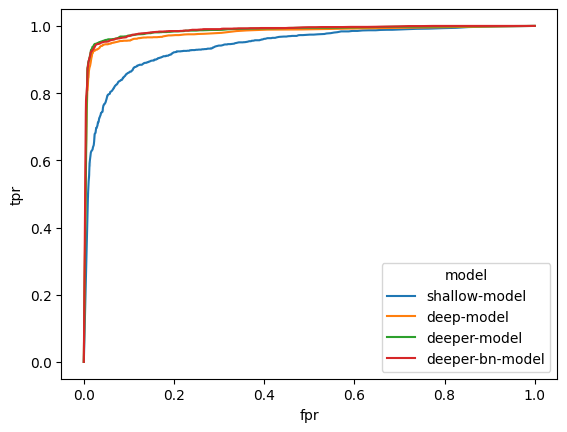

In [189]:
sns.lineplot(data=all_roc_data, x='fpr', y='tpr', hue='model')
plt.show()

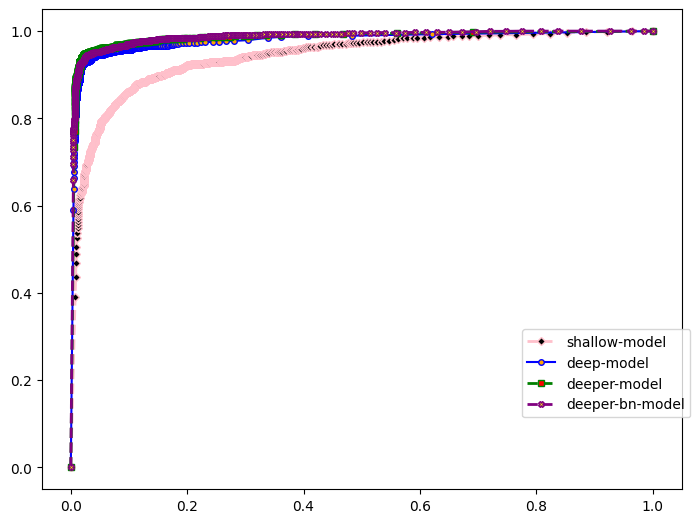

In [190]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.plot(shallow_fps,shallow_tps, label="shallow-model", 
        color='pink',
        lw=2,
        ls='--',
        marker='D',
        markerfacecolor='black',
        markeredgewidth=1,
        markeredgecolor='pink',
        markersize=4
       )  
ax.plot(deep_fps,deep_tps, label="deep-model", 
        color='blue',
        marker='o',
        markerfacecolor='orange',
        markeredgewidth=1,
        markeredgecolor='blue',
        markersize=4
       ) # basic chosen color
ax.plot(deeper_fps,deeper_tps, label="deeper-model", 
        color='green',
        lw=2,
        ls='--',
        marker='s',
        markerfacecolor='red',
        markeredgewidth=1,
        markeredgecolor='green',
        markersize=4
       )
ax.plot(deeper_bn_fps,deeper_bn_tps, label="deeper-bn-model", 
        color='purple',
        lw=2,
        ls='--',
        marker='X',
        markerfacecolor='yellow',
        markeredgewidth=1,
        markeredgecolor='purple',
        markersize=4
       )
ax.legend(loc=(0.75, 0.15)) # Can use a tuple to set it manually

In [191]:
print(f'Shallow Model AUC: {round(auc_score(shallow_tps, shallow_fps)[0],3)}')
print(f'Deep Model AUC: {round(auc_score(deep_tps, deep_fps)[0],3)}')
print(f'Deeper Model AUC: {round(auc_score(deeper_tps, deeper_fps)[0],3)}')
print(f'Deeper Model with Batch Normalization AUC: {round(auc_score(deeper_bn_tps, deeper_bn_fps)[0],3)}')

Shallow Model AUC: 0.941
Deep Model AUC: 0.979
Deeper Model AUC: 0.985
Deeper Model with Batch Normalization AUC: 0.987
